# Dataset generation

In [1]:
import subprocess
import h5py
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random
from time import time

### Parameters

Poseplan refears to a text file containing the allowed number of rotations for each class. It is used to take into account rotational invariance. We import this file to assign the rotation labels according to this strategy.

In [2]:
MN = 40

if MN == 10:
    dataset_path = "Dataset\ModelNet10_voxelized_mat"
    poseplan_path = "Dataset\poseplan_MN10.txt"
    h5file_path = 'Dataset\ModelNet10_dataset.h5'
else:
    dataset_path = "Dataset\ModelNet40_ma_voxelized_mat"
    poseplan_path = "Dataset\poseplan_MN40.txt"
    h5file_path = 'Dataset\ModelNet40_dataset.h5'
    
rot_angle = 30        # rotation angle used when generating views
perc_val = 20         # percentage of training set to be used to generate the validation set

In [3]:
modelnet_classes = subprocess.run('dir /ad /b "%s"'%dataset_path, shell=True, check=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[:-1]
print('ModelNet classes:\n',modelnet_classes)

ModelNet classes:
 ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']


### Folders management

In [4]:
# save all folder paths in the dataset
cmd = 'dir /ad /s /b "%s"'%dataset_path
list_folders = np.array(subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n'))

In [5]:
# distinguish between train and test folders
test_mask = np.char.find(list_folders,'test')+1
test_mask = test_mask.astype(bool)
train_mask = np.char.find(list_folders,'train')+1
train_mask = train_mask.astype(bool)

test_folders = list_folders[test_mask]
train_folders = list_folders[train_mask]

In the following, file will refer to a single mat file (one for each view of a 3D item), while object will refer to the specific 3D item regardless of its view.

In [6]:
# count the number of training files in the dataset
training_files = []
for folder in train_folders:
    list_files = subprocess.run('dir "%s"\*mat /b'%folder, shell=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[:-1]
    training_files += list_files
print(f'Number of training files = {len(training_files)}\nNumber of training objects = {len(training_files)*rot_angle//360}')

Number of training files = 118116
Number of training objects = 9843


In [7]:
# count the number of test files in the dataset
test_files = []
for folder in test_folders:
    list_files = subprocess.run('dir "%s"\*mat /b'%folder, shell=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[:-1]
    test_files += list_files
print(f'Number of test files = {len(test_files)}\nNumber of test objects = {len(test_files)*rot_angle//360}')

Number of test files = 29616
Number of test objects = 2468


### Extract a validation set from the train set

We generate a validation set such that multi views of a single object can not be partitioned between training and validation set. This helps in generating a validation set which is more representive as possible of the test set.

In [8]:
# separate the object from it's filename  (example:  filename='night_stand_0005_6.mat' => return 'night_stand_0005')
def sep_unique_file(filename):
    temp = filename.split('_')
    obj_name = ''
    for name_piece in temp[:-1]:
        obj_name += name_piece+'_'
    return obj_name[:-1]

# extract class and rotation information from the filename (example: 'sofa_0003_6.mat' => [array([7], dtype=int64), 5])
#    to be intended as: (7+1)th class (in ModelNet10) and (5+1)th views  (+1 due to the fact we start from 0)
def extract_class_and_rot(filename, modelnet_classes, rot_angle):
    filename = filename.split('_')
    mask = np.char.find(modelnet_classes, filename[0])+1
    mask = mask.astype(bool)
    return [np.where(mask)[0], int(filename[-1][:-4])-1]

# modify the rotation label to take into account rotational invariance
def rot_w_poseplan(class_, rot, poseplan):
    match poseplan[class_[0]]:
        case 1:  rot = 0            # poseplan = 1  =>  full rotational invariance
        case 3:  rot = rot % 3      # poseplan = 3  =>  rotational invariance for 90° angles
        case 6:  rot = rot % 6      # poseplan = 6  =>  rotational invariance for 180° angles
    return rot

In [9]:
# retrieve a list of all objects in the training set
training_objs = [sep_unique_file(filename) for filename in training_files]
training_objs = np.unique(training_objs)

In [10]:
# extract a list of objects to be inserted in the validation set
random.seed(42)
num_val = perc_val*len(training_objs)//100
val_objs = random.sample(list(training_objs), num_val)        # list of objects in validation set
val_class = [sep_unique_file(obj) for obj in val_objs]        # list of categories in validation set

### Study distribution of classes in training, validation and test set

In [22]:
# count the numbers of files in the validation set for each class
val_set_size = num_val * 360//rot_angle
count_objs_per_class_val = []
for class_ in modelnet_classes:
    mask = np.char.find(val_class,class_)+1
    count_objs_per_class_val.append(sum(mask)*360//rot_angle)
print('---- VALIDATION SET ----')
print('Num of samples in each class (views included):',count_objs_per_class_val)
print(f'Validation set size = {sum(count_objs_per_class_val)}\t\t({sum(count_objs_per_class_val)==val_set_size})')
print(f'Number of training objects (no views included) = {val_set_size*rot_angle//360}')

---- VALIDATION SET ----
Num of samples in each class (views included): [1296, 300, 1416, 516, 1344, 792, 156, 576, 1824, 432, 216, 324, 612, 336, 444, 408, 456, 396, 348, 348, 372, 696, 1104, 408, 288, 432, 576, 216, 336, 336, 1896, 228, 228, 864, 276, 804, 636, 1020, 240, 120]
Validation set size = 23616		(True)
Number of training objects (no views included) = 1968


In [23]:
# count the numbers of files in the training set for each class
train_set_size = len(training_files) - val_set_size
train_class = [sep_unique_file(obj) for obj in training_objs]
count_objs_per_class_train = []
for class_ in modelnet_classes:
    mask = np.char.find(train_class,class_)+1
    count_objs_per_class_train.append(sum(mask)*360//rot_angle)
count_objs_per_class_train = np.array(count_objs_per_class_train) - np.array(count_objs_per_class_val)
print('---- TRAINING SET ----')
print('Num of samples in each class (rot included):',count_objs_per_class_train)
print(f'Training set size = {sum(count_objs_per_class_train)}\t\t({sum(count_objs_per_class_train)==train_set_size})')
print(f'Number of training objects (no views included) = {train_set_size*rot_angle//360}')

---- TRAINING SET ----
Num of samples in each class (rot included): [6216  972 4764 1560 5520 3228  612 1788 8844 1572  732 1332 1788  972
 1956 1380 1596 1464 1392 1140 1416 2712 4476 1992  768 2340 2304 1032
 1044 1200 6264 1260  852 3840 1680 3324 2568 4680  804 1116]
Training set size = 94500		(True)
Number of training objects (no views included) = 7875


In [24]:
# count the numbers of files in the test set for each class
test_set_size = len(test_files)
test_objs = [sep_unique_file(filename) for filename in test_files]
test_class = [sep_unique_file(obj) for obj in test_objs]
count_objs_per_class_test = []
for class_ in modelnet_classes:
    mask = np.char.find(test_class,class_)+1
    count_objs_per_class_test.append(sum(mask))
print('---- TEST SET ----')
print('Num of samples in each class (rot included):',count_objs_per_class_test)
print(f'Test set size = {sum(count_objs_per_class_test)}\t\t({sum(count_objs_per_class_test)==test_set_size})')
print(f'Number of test objects (no views included) = {test_set_size*rot_angle//360}')

---- TEST SET ----
Num of samples in each class (rot included): [1200, 600, 1200, 240, 1200, 1200, 240, 1200, 1200, 240, 240, 240, 1032, 240, 1032, 240, 1200, 1200, 240, 240, 240, 1200, 1200, 1032, 240, 1200, 1200, 240, 1200, 240, 1200, 240, 240, 1200, 240, 1200, 1200, 1200, 240, 240]
Test set size = 29616		(True)
Number of test objects (no views included) = 2468


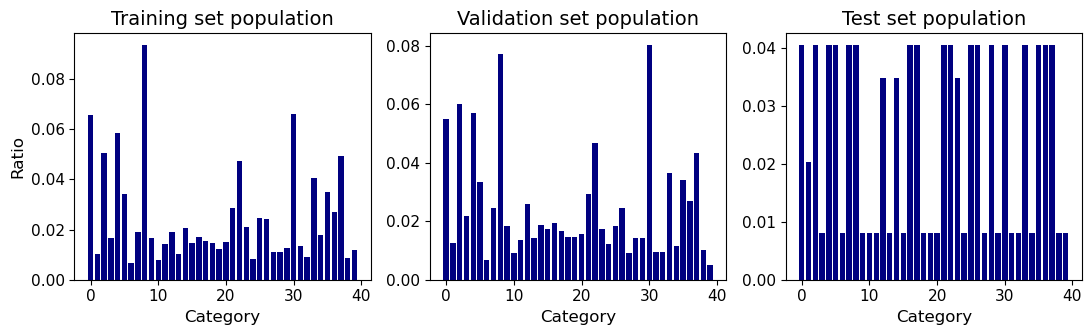

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3.2))

P_train = [i/sum(count_objs_per_class_train) for i in count_objs_per_class_train]
P_val = [i/sum(count_objs_per_class_val) for i in count_objs_per_class_val]
P_test = [i/sum(count_objs_per_class_test) for i in count_objs_per_class_test]

bars = ax1.bar(range(len(modelnet_classes)), P_train, color='navy')
ax1.set_title('Training set population', fontsize=14)
ax1.set_xlabel('Category', fontsize=12)
ax1.tick_params(labelsize=11)
ax1.set_ylabel('Ratio', fontsize=12)

bars = ax2.bar(range(len(modelnet_classes)), P_val, color='navy')
ax2.set_title('Validation set population', fontsize=14)
ax2.set_xlabel('Category', fontsize=12)
ax2.tick_params(labelsize=11)
    
bars = ax3.bar(range(len(modelnet_classes)), P_test, color='navy')
ax3.set_title('Test set population', fontsize=14)
ax3.set_xlabel('Category', fontsize=12)
ax3.tick_params(labelsize=11)

From the plots above, we note how the test set has a different distribution then training and validation ones

Number of 3D objects in each dataset:

| | MN10 | MN40 |
|:---:|:---:|:---:|
|Training | 3193 | 7875 |
|Validation | 798 | 1968 |
|Test | 908 | 2468 |

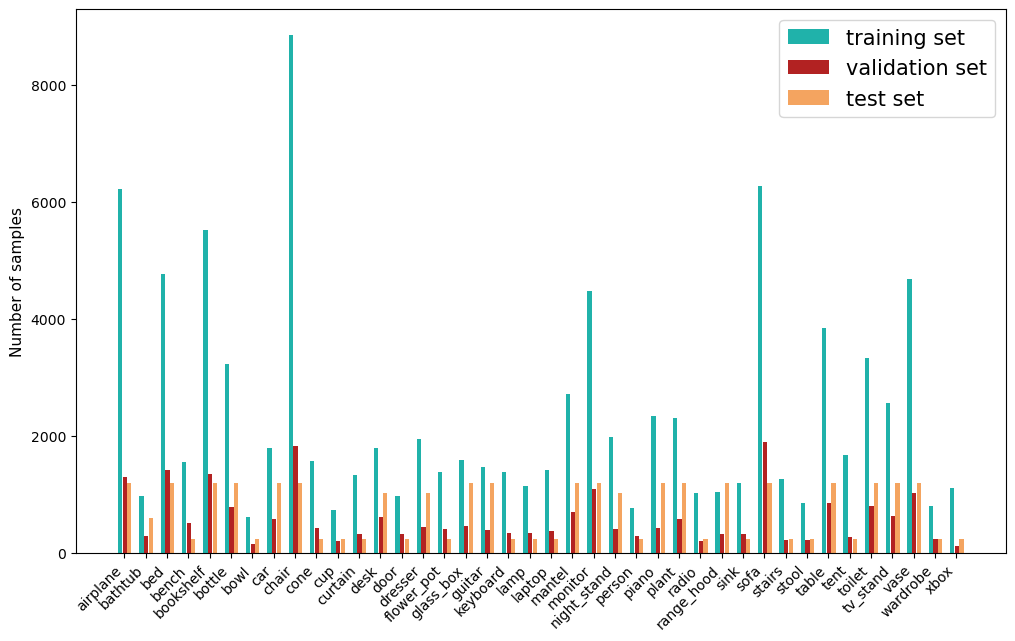

In [21]:
barWidth = 0.2
fig, ax = plt.subplots(figsize =(12, 8))
fig.autofmt_xdate(rotation=45)

br1 = np.arange(len(count_objs_per_class_train))
br2 = [x + barWidth + 0.015 for x in br1]
br3 = [x + barWidth + 0.015 for x in br2]
 
plt.bar(br1, count_objs_per_class_train, color ='lightseagreen', width = barWidth, label ='training set')
plt.bar(br2, count_objs_per_class_val, color ='firebrick', width = barWidth, label ='validation set')
plt.bar(br3, count_objs_per_class_test, color ='sandybrown', width = barWidth, label ='test set')
 
#plt.xlabel('lass', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 11)
plt.xticks([r + barWidth for r in range(len(count_objs_per_class_train))], modelnet_classes, fontsize=10)
 
plt.legend(fontsize=15)
plt.show()

### Save dataset in a HDF5 file

Generate the dataset HDF5 file and read poseplan information

In [17]:
hf = h5py.File(h5file_path, 'w')

In [18]:
pp_file = open(poseplan_path)
pp_content = pp_file.readlines()
poseplan = []
for line in pp_content:
    temp = line.split('\t')
    poseplan.append(int(temp[1]))
pp_file.close()

#### Fill the training set

In [19]:
start = time()

Find the first files belonging to training and validation set

In [20]:
cond_train, cond_val = False, False
first_train_folder, first_val_folder = '', ''
for folder in train_folders:
    list_files = subprocess.run('dir "%s"\*mat /b'%folder, shell=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[:-1]
    for file in list_files:
        obj = sep_unique_file(file)
        if obj not in val_objs and first_train_folder == '':
            first_train_folder, first_train_file = folder, file
            cond_train = True
        elif obj in val_objs and first_val_folder == '':
            first_val_folder, first_val_file = folder, file
            cond_val = True
    if cond_train and cond_val:
        break

Initialize training dataset with first training item. 

In the following, rot and rot_pp will refer respectively to rotation labels without and with considering rotational invariance.

In [21]:
# load the item in memory
vox = loadmat(first_train_folder+'\\'+first_train_file)['instance']
vox_shape = vox.shape
vox = vox.reshape(1,vox.shape[0],vox.shape[1],vox.shape[2])

# extract category and rotation labels
class1, rot1 = extract_class_and_rot(first_train_file, modelnet_classes, rot_angle)
class1, rot1, rot1_pp = class1.reshape(1,1), np.array([rot1]).reshape(1,1), np.array([rot_w_poseplan(class1, rot1, poseplan)]).reshape(1,1)

In [22]:
hf.create_dataset('X_train', data=vox, compression="gzip", chunks=(1,vox_shape[0],vox_shape[1],vox_shape[2]), dtype='<i1', maxshape=(None,vox_shape[0],vox_shape[1],vox_shape[2]))
hf.create_dataset('Y_train', data=class1, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))
hf.create_dataset('rot_train', data=rot1, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))
hf.create_dataset('rot_train_pp', data=rot1_pp, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))

<HDF5 dataset "rot_train_pp": shape (1, 1), type "|i1">

Fill training set with all training items

In [23]:
for folder in train_folders:
    print('Writing class: %s'%{folder.split("\\")[-3]})
    list_files = subprocess.run('dir "%s"\*mat /b'%folder, shell=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[:-1]
    for file in list_files:
        obj = sep_unique_file(file)
        if file != first_train_file and obj not in val_objs:
            new_len = hf["Y_train"].shape[0] + 1
            hf["X_train"].resize(new_len, axis = 0)
            hf["Y_train"].resize(new_len, axis = 0)
            hf["rot_train"].resize(new_len, axis = 0)
            hf["rot_train_pp"].resize(new_len, axis = 0)
            
            vox = loadmat(folder + '\\' + file)['instance']
            vox = vox.reshape(1,vox.shape[0],vox.shape[1],vox.shape[2])
            class_, rot_ = extract_class_and_rot(file, modelnet_classes, rot_angle)
            class_, rot_, rot_pp_ = class_.reshape(1,1), np.array([rot_]).reshape(1,1), np.array([rot_w_poseplan(class_, rot_, poseplan)]).reshape(1,1)
            
            hf["X_train"][-1] = vox
            hf["Y_train"][-1] = class_
            hf["rot_train"][-1] = rot_
            hf["rot_train_pp"][-1] = rot_pp_

Writing class: {'airplane'}
Writing class: {'bathtub'}
Writing class: {'bed'}
Writing class: {'bench'}
Writing class: {'bookshelf'}
Writing class: {'bottle'}
Writing class: {'bowl'}
Writing class: {'car'}
Writing class: {'chair'}
Writing class: {'cone'}
Writing class: {'cup'}
Writing class: {'curtain'}
Writing class: {'desk'}
Writing class: {'door'}
Writing class: {'dresser'}
Writing class: {'flower_pot'}
Writing class: {'glass_box'}
Writing class: {'guitar'}
Writing class: {'keyboard'}
Writing class: {'lamp'}
Writing class: {'laptop'}
Writing class: {'mantel'}
Writing class: {'monitor'}
Writing class: {'night_stand'}
Writing class: {'person'}
Writing class: {'piano'}
Writing class: {'plant'}
Writing class: {'radio'}
Writing class: {'range_hood'}
Writing class: {'sink'}
Writing class: {'sofa'}
Writing class: {'stairs'}
Writing class: {'stool'}
Writing class: {'table'}
Writing class: {'tent'}
Writing class: {'toilet'}
Writing class: {'tv_stand'}
Writing class: {'vase'}
Writing class: {'

#### Fill the validation set

Initialize validation dataset with first validation item. 

In [24]:
# load the item in memory
vox = loadmat(first_val_folder+'\\'+first_val_file)['instance']
vox = vox.reshape(1,vox.shape[0],vox.shape[1],vox.shape[2])

# extract category and rotation labels
class1, rot1 = extract_class_and_rot(first_val_file, modelnet_classes, rot_angle)
class1, rot1, rot1_pp = class1.reshape(1,1), np.array([rot1]).reshape(1,1), np.array([rot_w_poseplan(class1, rot1, poseplan)]).reshape(1,1)

In [25]:
hf.create_dataset('X_val', data=vox, compression="gzip", chunks=(1,vox_shape[0],vox_shape[1],vox_shape[2]), dtype='<i1', maxshape=(None,vox_shape[0],vox_shape[1],vox_shape[2]))
hf.create_dataset('Y_val', data=class1, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))
hf.create_dataset('rot_val', data=rot1, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))
hf.create_dataset('rot_val_pp', data=rot1_pp, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))

<HDF5 dataset "rot_val_pp": shape (1, 1), type "|i1">

Fill validation set with all validation items

In [26]:
for folder in train_folders:
    print('Writing class: %s'%{folder.split("\\")[-3]})
    list_files = subprocess.run('dir "%s"\*mat /b'%folder, shell=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[:-1]
    for file in list_files:
        obj = sep_unique_file(file)
        if file != first_val_file and obj in val_objs:
            new_len = hf["Y_val"].shape[0] + 1
            hf["X_val"].resize(new_len, axis = 0)
            hf["Y_val"].resize(new_len, axis = 0)
            hf["rot_val"].resize(new_len, axis = 0)
            hf["rot_val_pp"].resize(new_len, axis = 0)
            
            vox = loadmat(folder + '\\' + file)['instance']
            vox = vox.reshape(1,vox.shape[0],vox.shape[1],vox.shape[2])
            class_, rot_ = extract_class_and_rot(file, modelnet_classes, rot_angle)
            class_, rot_, rot_pp_ = class_.reshape(1,1), np.array([rot_]).reshape(1,1), np.array([rot_w_poseplan(class_, rot_, poseplan)]).reshape(1,1)
            
            hf["X_val"][-1] = vox
            hf["Y_val"][-1] = class_
            hf["rot_val"][-1] = rot_
            hf["rot_val_pp"][-1] = rot_pp_

Writing class: {'airplane'}
Writing class: {'bathtub'}
Writing class: {'bed'}
Writing class: {'bench'}
Writing class: {'bookshelf'}
Writing class: {'bottle'}
Writing class: {'bowl'}
Writing class: {'car'}
Writing class: {'chair'}
Writing class: {'cone'}
Writing class: {'cup'}
Writing class: {'curtain'}
Writing class: {'desk'}
Writing class: {'door'}
Writing class: {'dresser'}
Writing class: {'flower_pot'}
Writing class: {'glass_box'}
Writing class: {'guitar'}
Writing class: {'keyboard'}
Writing class: {'lamp'}
Writing class: {'laptop'}
Writing class: {'mantel'}
Writing class: {'monitor'}
Writing class: {'night_stand'}
Writing class: {'person'}
Writing class: {'piano'}
Writing class: {'plant'}
Writing class: {'radio'}
Writing class: {'range_hood'}
Writing class: {'sink'}
Writing class: {'sofa'}
Writing class: {'stairs'}
Writing class: {'stool'}
Writing class: {'table'}
Writing class: {'tent'}
Writing class: {'toilet'}
Writing class: {'tv_stand'}
Writing class: {'vase'}
Writing class: {'

#### Fill the test set

Initialize validation dataset with first validation item.

In [27]:
# load first test item in memory
first_test_file = subprocess.run('dir "%s"\*mat /b'%test_folders[0], shell=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[0]
vox = loadmat(test_folders[0]+'\\'+first_test_file)['instance']
vox = vox.reshape(1,vox.shape[0],vox.shape[1],vox.shape[2])

# extract category and rotation labels
class1, rot1 = extract_class_and_rot(first_test_file, modelnet_classes, rot_angle)
class1, rot1, rot1_pp = class1.reshape(1,1), np.array([rot1]).reshape(1,1), np.array([rot_w_poseplan(class1, rot1, poseplan)]).reshape(1,1)

In [28]:
hf.create_dataset('X_test', data=vox, compression="gzip", chunks=(1,vox_shape[0],vox_shape[1],vox_shape[2]), dtype='<i1', maxshape=(None,vox_shape[0],vox_shape[1],vox_shape[2]))
hf.create_dataset('Y_test', data=class1, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))
hf.create_dataset('rot_test', data=rot1, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))
hf.create_dataset('rot_test_pp', data=rot1_pp, compression="gzip", chunks=(1,1), dtype='<i1', maxshape=(None,1))

<HDF5 dataset "rot_test_pp": shape (1, 1), type "|i1">

Fill test set with all test items

In [29]:
for folder in test_folders:
    print('Writing class: %s'%{folder.split("\\")[-3]})
    list_files = subprocess.run('dir "%s"\*mat /b'%folder, shell=True, stdout=subprocess.PIPE).stdout.decode('latin_1').split('\r\n')[:-1]
    for file in list_files:
        if file != first_test_file:
            new_len = hf["Y_test"].shape[0] + 1
            hf["X_test"].resize(new_len, axis = 0)
            hf["Y_test"].resize(new_len, axis = 0)
            hf["rot_test"].resize(new_len, axis = 0)
            hf["rot_test_pp"].resize(new_len, axis = 0)
            
            vox = loadmat(folder + '\\' + file)['instance']
            vox = vox.reshape(1,vox.shape[0],vox.shape[1],vox.shape[2])
            class_, rot_ = extract_class_and_rot(file, modelnet_classes, rot_angle)
            class_, rot_, rot_pp_ = class_.reshape(1,1), np.array([rot_]).reshape(1,1), np.array([rot_w_poseplan(class_, rot_, poseplan)]).reshape(1,1)
            
            hf["X_test"][-1] = vox
            hf["Y_test"][-1] = class_
            hf["rot_test"][-1] = rot_
            hf["rot_test_pp"][-1] = rot_pp_

Writing class: {'airplane'}
Writing class: {'bathtub'}
Writing class: {'bed'}
Writing class: {'bench'}
Writing class: {'bookshelf'}
Writing class: {'bottle'}
Writing class: {'bowl'}
Writing class: {'car'}
Writing class: {'chair'}
Writing class: {'cone'}
Writing class: {'cup'}
Writing class: {'curtain'}
Writing class: {'desk'}
Writing class: {'door'}
Writing class: {'dresser'}
Writing class: {'flower_pot'}
Writing class: {'glass_box'}
Writing class: {'guitar'}
Writing class: {'keyboard'}
Writing class: {'lamp'}
Writing class: {'laptop'}
Writing class: {'mantel'}
Writing class: {'monitor'}
Writing class: {'night_stand'}
Writing class: {'person'}
Writing class: {'piano'}
Writing class: {'plant'}
Writing class: {'radio'}
Writing class: {'range_hood'}
Writing class: {'sink'}
Writing class: {'sofa'}
Writing class: {'stairs'}
Writing class: {'stool'}
Writing class: {'table'}
Writing class: {'tent'}
Writing class: {'toilet'}
Writing class: {'tv_stand'}
Writing class: {'vase'}
Writing class: {'

In [30]:
hf.close()

In [31]:
end = time()
print(f'Execution time = {end-start} s')

Execution time = 2246.727951526642 s


### Read dataset content

In [15]:
h5file_path = 'Dataset\ModelNet40_ma_dataset.h5'
#h5file_path = 'Dataset\ModelNet10_dataset.h5'

hf = h5py.File(h5file_path, 'r')

HDF5 datasets contained in the file

In [16]:
hf.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'Y_test', 'Y_train', 'Y_val', 'rot_test', 'rot_test_pp', 'rot_train', 'rot_train_pp', 'rot_val', 'rot_val_pp']>

Chunks dimension

In [17]:
chunks_dim = hf['X_train'].chunks
print(f'Chunks dimension = {chunks_dim}')

# data is saved in int1 format
num_bytes = np.prod(chunks_dim)
num_kiB = num_bytes / 1024
print(f'Memory required per chunk = {num_kiB} kiB')

Chunks dimension = (1, 32, 32, 32)
Memory required per chunk = 32.0 kiB


Read train, validation or test set

In [18]:
type_ = 'test'
data_x = hf['X_'+type_]
data_y = hf['Y_'+type_]
data_rot = hf['rot_'+type_]
data_rot_pp = hf['rot_'+type_+'_pp']

In [19]:
X_shape = data_x.shape
print(X_shape)

(29616, 32, 32, 32)


Visualize a sample from the test set

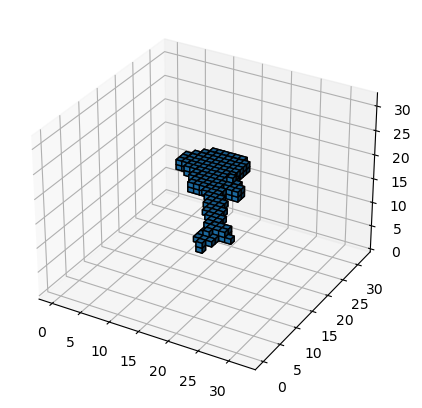

Class =  17 	 (guitar)
Rotation = 10


In [20]:
idx=13034

ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
ax.voxels(data_x[idx], edgecolor='k')
plt.show()

print(f'Class =  {int(data_y[idx])} \t ({modelnet_classes[int(data_y[idx])]})')
print(f'Rotation = {int(data_rot[idx])}')

Visualize all available views of the same object.  
In this case, a monitor is showed. This category has a rotational invariance for angles of 180°. The two numbers dysplayed above each plot are respectively the angle of rotation, and the same quantity when considering rotational invariance.

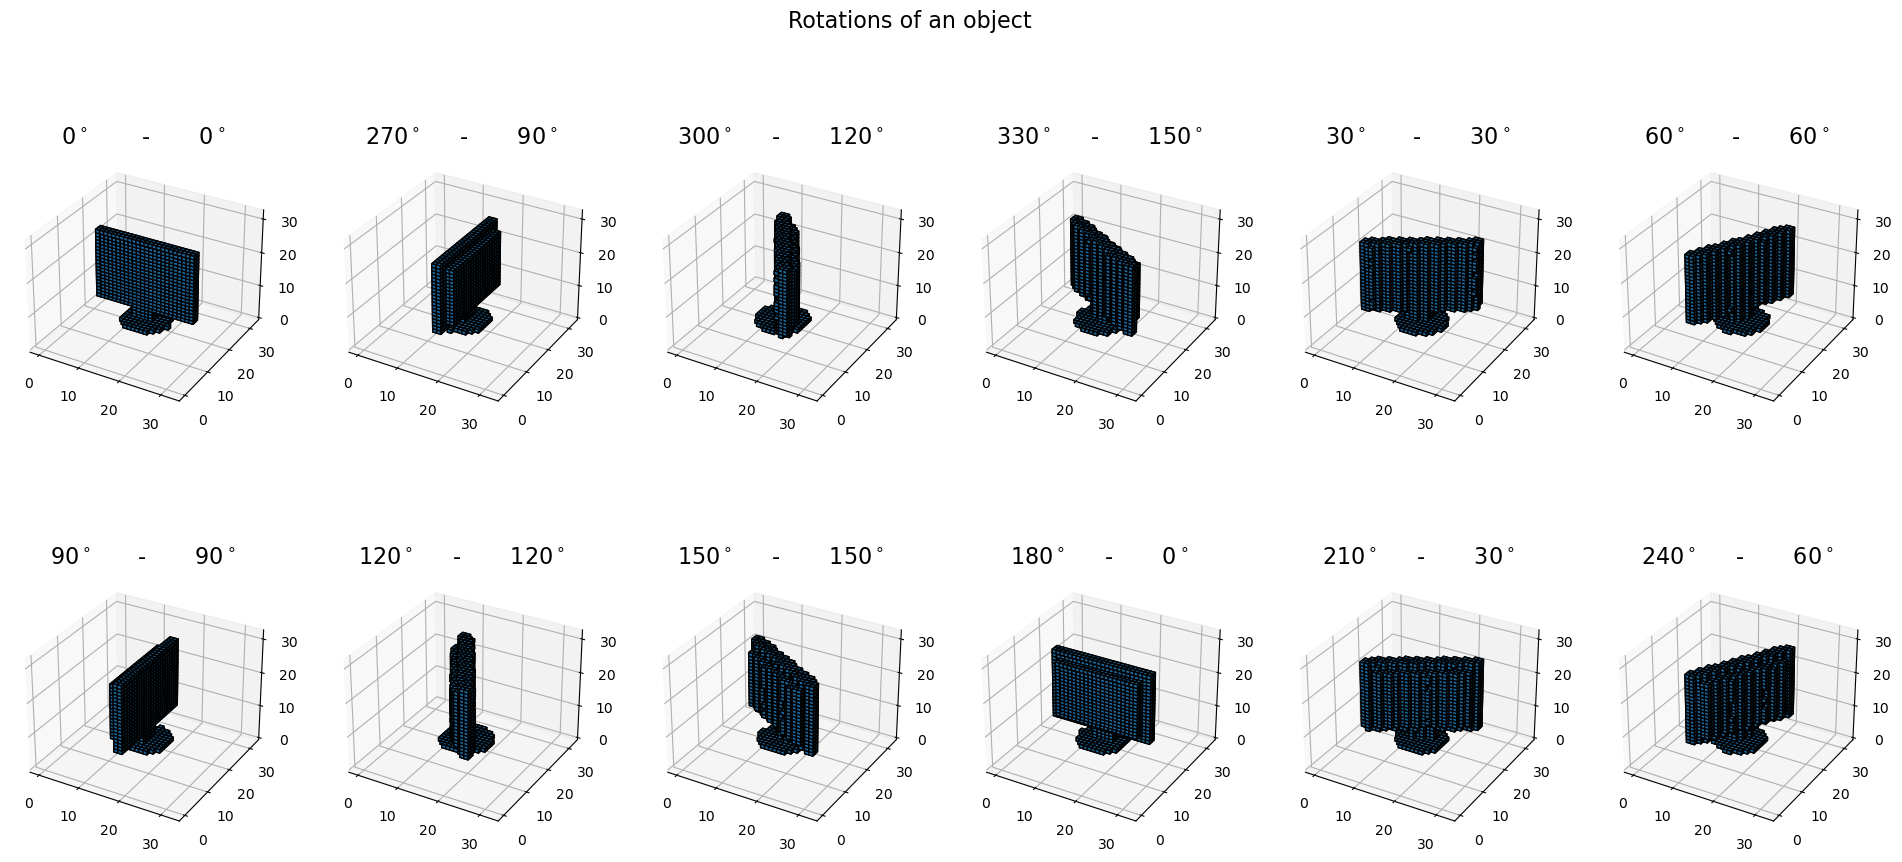

In [21]:
idx = 16824
fig_shape = (2, 6)
fig = plt.figure(figsize=(24,10))
for i in range(np.prod(fig_shape)):
    ax = fig.add_subplot(2, 6, i+1, projection='3d')
    ax.voxels(data_x[idx+i], edgecolor='k')
    ax.set_title(str(data_rot[idx+i][0]*rot_angle)+'$^\circ$\t-\t'+str(data_rot_pp[idx+i][0]*rot_angle)+'$^\circ$',fontsize=16)
fig.suptitle('Rotations of an object', fontsize=16)
plt.show()

Below, we will show different objects (chairs) with the same viewpoint. This plot certifies that the items in the dataset are correctly aligned.

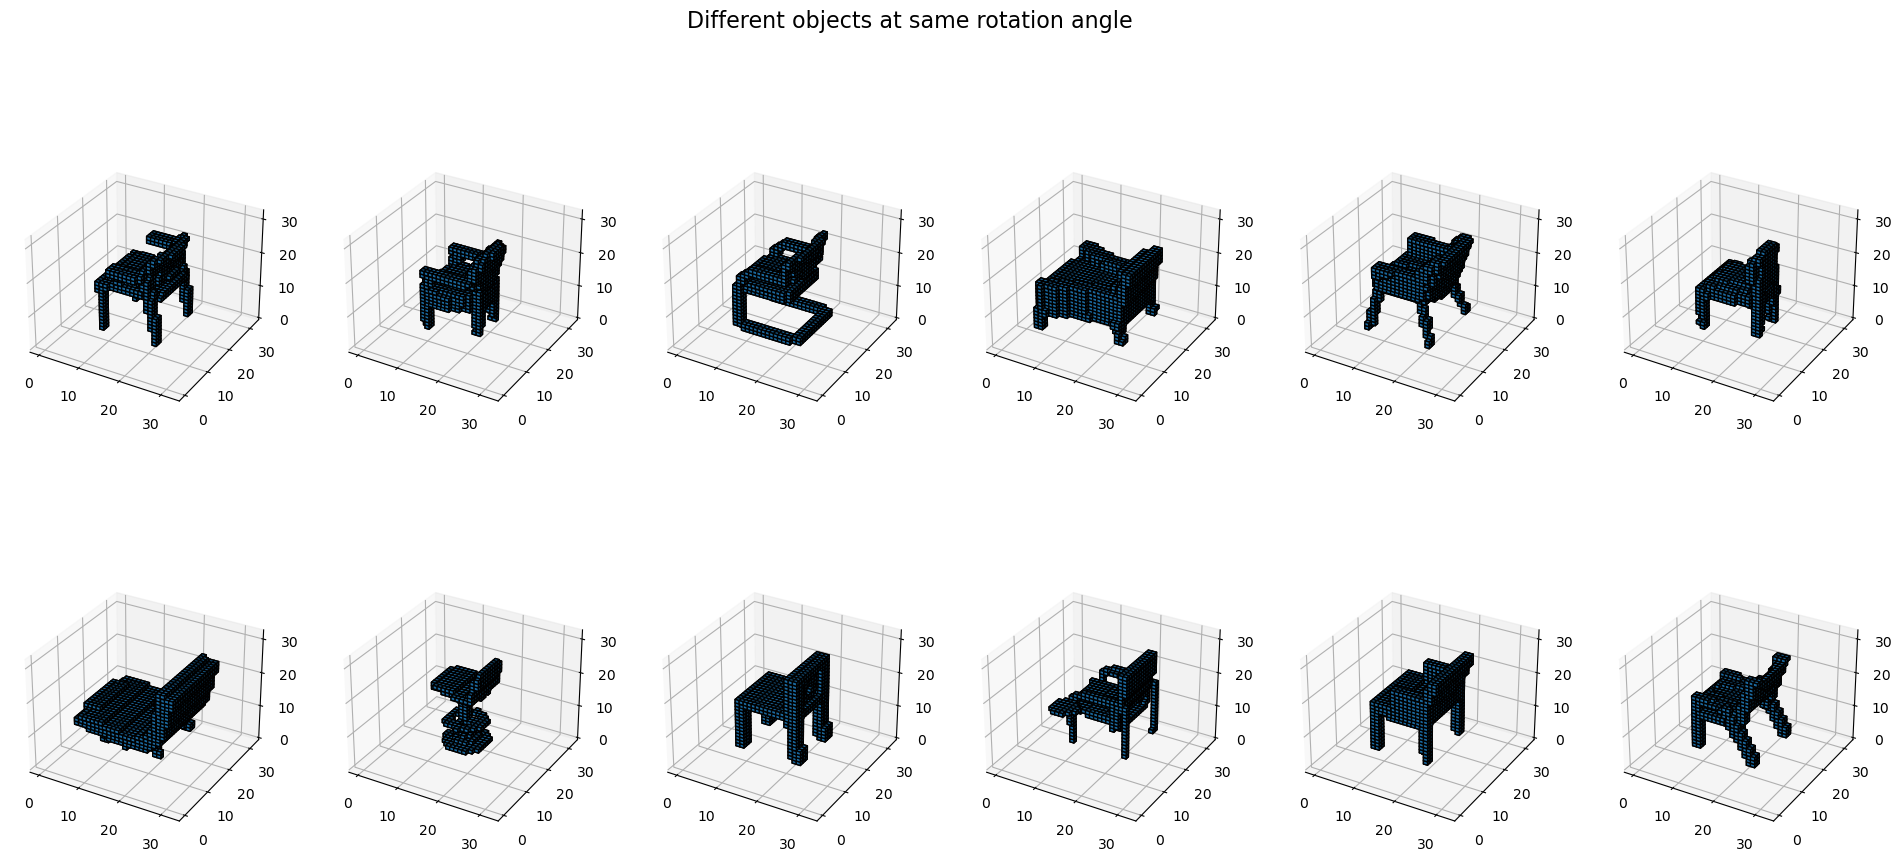

In [22]:
idx= 7200
fig_shape = (2, 6)
fig = plt.figure(figsize=(24,10))
for i in range(np.prod(fig_shape)):
    ax = fig.add_subplot(2, 6, i+1, projection='3d')
    ax.voxels(data_x[idx+12*i], edgecolor='k')
fig.suptitle('Different objects at same rotation angle', fontsize=16)
plt.show()

In [23]:
hf.close()